# Validating and Inspecting Time Series Models
>  Once you've got a model for predicting time series data, you need to decide if it's a good or a bad model. This chapter coves the basics of generating predictions with models in order to validate them against "test" data.

- toc: true 
- badges: true
- comments: true
- author: Lucas Nunes
- categories: [Python, Datacamp, Machine Learning]
- image: images/datacamp/1_supervised_learning_with_scikit_learn/2_regression.png

> Note: This is a summary of the course's chapter 4 exercises "Machine Learning for Time Series Data in Python" at datacamp. <br>[Github repo](https://github.com/lnunesAI/Datacamp/) / [Course link](https://www.datacamp.com/tracks/machine-learning-scientist-with-python)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
# plt.style.use('fivethirtyeight')
#plt.rcParams['image.cmap'] = 'inferno'

## Creating features from the past

### Creating time-shifted features


<div class=""><p>In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.</p>
<p>In this exercise, you'll "shift" your raw data and visualize the results. You'll use the <em>percent change</em> time series
that you calculated in the previous chapter, this time with a <em>very short</em> window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.</p></div>

In [ ]:
all_prices = pd.read_csv('https://raw.githubusercontent.com/lnunesAI/Datacamp/main/2-machine-learning-scientist-with-python/9-machine-learning-for-time-series-data-in-python/datasets/prices_1762x4.csv', index_col=0, parse_dates=True)
prices = all_prices[['AAPL']]

In [ ]:
#@title ⠀ { display-mode: "form" }
def percent_change(series):
    previous_values = series[:-1]
    return (series[-1] - np.mean(previous_values)) / np.mean(previous_values)

def replace_outliers(series):
    # Calculate a mask for values that are > 3 standard deviations after centering
    this_mask = np.abs(series - np.mean(series)) > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

prices_perc = prices.rolling(20).apply(percent_change)
prices_perc = prices_perc.apply(replace_outliers)

Instructions
<ul>
<li>Use a dictionary comprehension to create multiple time-shifted versions of <code>prices_perc</code> using the lags specified in <code>shifts</code>. </li>
<li>Convert the result into a DataFrame. </li>
<li>Use the given code to visualize the results.</li>
</ul>

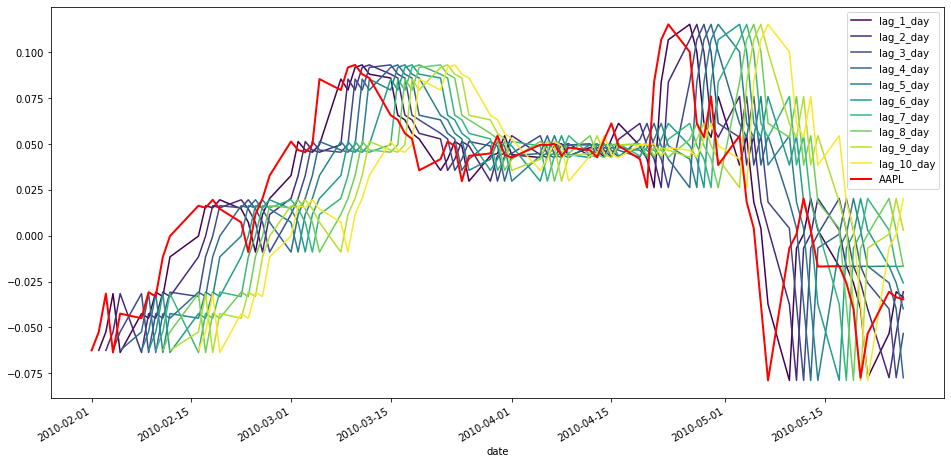

In [ ]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): 
                prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
fig, ax = plt.subplots(figsize=(16, 8));
prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis, ax=ax);
prices_perc.iloc[:100].plot(color='r', lw=2, ax=ax);
ax.legend(loc='best');

### Special case: Auto-regressive models


<div class=""><p>Now that you've created time-shifted versions of a single time series, you can fit an <em>auto-regressive</em> model. This is a regression
model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).</p>
<p>By investigating the coefficients of this
model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.</p></div>

In [ ]:
from sklearn.linear_model import Ridge

Instructions
<ul>
<li>Replace missing values in <code>prices_perc_shifted</code> with the median of the DataFrame and assign it to <code>X</code>. </li>
<li>Replace missing values in <code>prices_perc</code> with the median of the series and assign it to <code>y</code>. </li>
<li>Fit a regression model using the <code>X</code> and <code>y</code> arrays.</li>
</ul>

In [ ]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc['AAPL'].fillna(np.nanmedian(prices_perc['AAPL']))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

**You've filled in the missing values with the median so that it behaves well with scikit-learn. Now let's take a look at what your model found.**

### Visualize regression coefficients


<div class=""><p>Now that you've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.</p>
<p>The shifted time series DataFrame (<code>prices_perc_shifted</code>) and the regression model (<code>model</code>) are available in your workspace. </p>
<p>In this exercise, you will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.</p></div>

Instructions 1/2
<p>Define a function (called <code>visualize_coefficients</code>) that takes as input an array of coefficients, an array of each coefficient's name, and an instance of a Matplotlib axis object. It should then generate a bar plot for the input coefficients, with their names on the x-axis.</p>

In [ ]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

Instructions 2/2

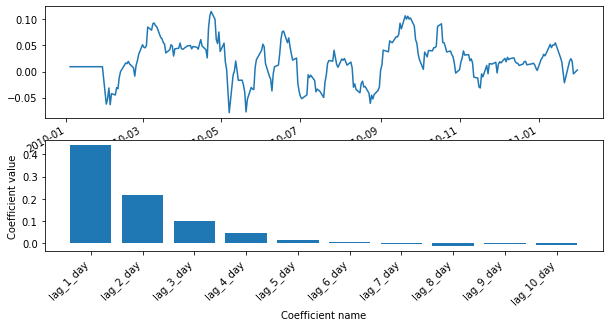

In [ ]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

**When you use time-lagged features on the raw data, you see that the highest coefficient by far is the first one. This means that the N-1th time point is useful in predicting the Nth timepoint, but no other points are useful.**

### Auto-regression with a smoother time series


<div class=""><p>Now, let's re-run the same procedure using a smoother signal. You'll use the same <em>percent change</em> algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a <em>smoother</em> signal. What do you think this will do to the auto-regressive model?</p>
<p><code>prices_perc_shifted</code> and <code>model</code> (updated to use a window of 40) are available in your workspace.</p></div>

In [ ]:
prices_perc = prices.rolling(40).apply(percent_change)
prices_perc = prices_perc.apply(replace_outliers)
shifted_data = {"lag_{}_day".format(day_shift): prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}
prices_perc_shifted = pd.DataFrame(shifted_data)
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc['AAPL'].fillna(np.nanmedian(prices_perc['AAPL']))
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Instructions
<p>Using the function (<code>visualize_coefficients()</code>) you created in the last exercise, generate a plot with coefficients of <code>model</code> and column names of <code>prices_perc_shifted</code>.</p>

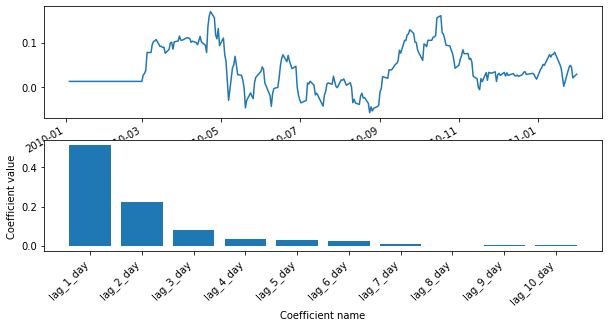

In [ ]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

**As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d.**

## Cross-validating time series data

<div class=""><p>As you'll recall, cross-validation is the process of splitting your data into training and test sets multiple times. Each time you do this, you choose a <em>different</em> training and test set. In this exercise, you'll perform a traditional <code>ShuffleSplit</code> cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.</p>
<p>An instance of the Linear regression object (<code>model</code>) is available in your workspace along with the function <code>r2_score()</code> for scoring. Also, the data is stored in arrays <code>X</code> and <code>y</code>. We've also provided a helper function (<code>visualize_predictions()</code>) to help visualize the results.</p></div>

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lnunesAI/Datacamp/main/2-machine-learning-scientist-with-python/9-machine-learning-for-time-series-data-in-python/datasets/prices_cv_400x11.csv')

In [ ]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()


model = LinearRegression()


Instructions
<ul>
<li>Initialize a ShuffleSplit cross-validation object with 10 splits. </li>
<li>Iterate through CV splits using this object. On each iteration:<ul>
<li>Fit a model using the training indices. </li>
<li>Generate predictions using the test indices, score the model (<mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" role="presentation" tabindex="0" ctxtmenu_counter="1" style="font-size: 116.7%; position: relative;"><mjx-math class="MJX-TEX" aria-hidden="true"><mjx-msup><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D445 TEX-I"></mjx-c></mjx-mi><mjx-script style="vertical-align: 0.363em;"><mjx-mn class="mjx-n" size="s"><mjx-c class="mjx-c32"></mjx-c></mjx-mn></mjx-script></mjx-msup></mjx-math><mjx-assistive-mml role="presentation" unselectable="on" display="inline"><math xmlns="http://www.w3.org/1998/Math/MathML"><msup><mi>R</mi><mn>2</mn></msup></math></mjx-assistive-mml></mjx-container>) using the predictions, and collect the results.</li></ul></li>
</ul>

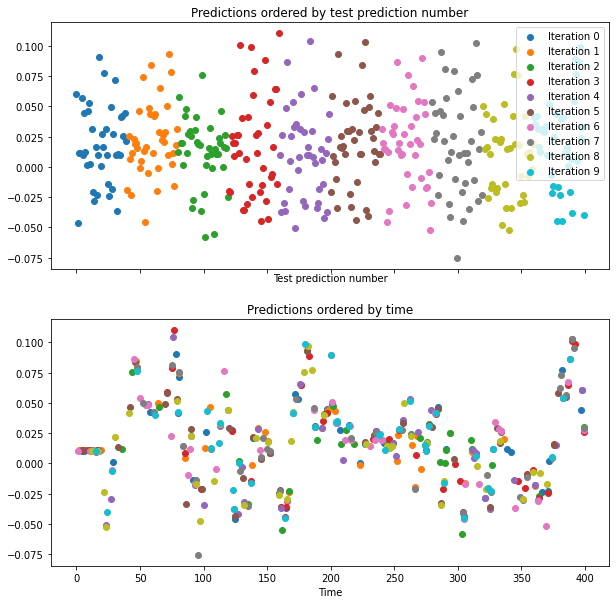

In [ ]:
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

**If you look at the plot to the right, see that the order of datapoints in the test set is scrambled. Let's see how it looks when we shuffle the data in blocks.**

### Cross-validation without shuffling


<div class=""><p>Now, re-run your model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop? </p>
<p>An instance of the Linear regression <code>model</code> object is available in your workspace. Also, the arrays <code>X</code> and <code>y</code> (training data) are available too.</p></div>

In [ ]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

Instructions
<ul>
<li>Instantiate another cross-validation object, this time using KFold cross-validation with 10 splits and no shuffling.</li>
<li>Iterate through this object to fit a model using the training indices and generate predictions using the test indices. </li>
<li>Visualize the predictions across CV splits using the helper function (<code>visualize_predictions()</code>) we've provided.</li>
</ul>

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


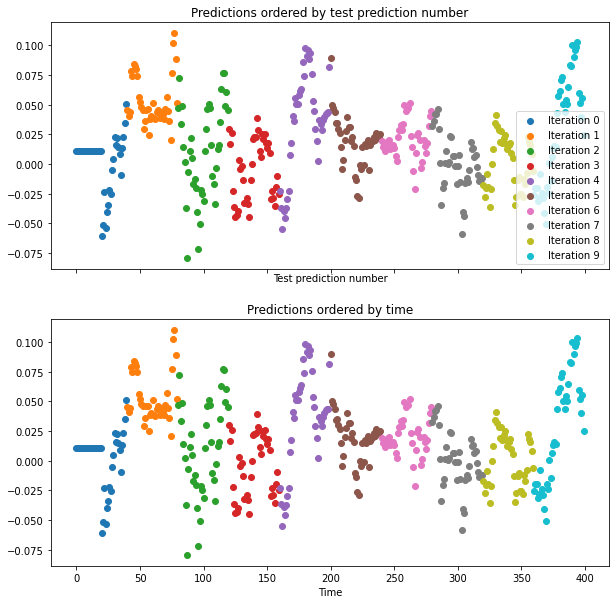

In [ ]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt)) #results.append((prediction, _, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

**This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because you didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct.**

### Time-based cross-validation


<div class=""><p>Finally, let's visualize the behavior of the <em>time series cross-validation iterator</em> in scikit-learn. Use this object to iterate through your data one last time, visualizing the training data used to fit the model on each iteration. </p>
<p>An instance of the Linear regression <code>model</code> object is available in your workpsace. Also, the arrays <code>X</code> and <code>y</code> (training data) are available too.</p></div>

Instructions
<ul>
<li>Import <code>TimeSeriesSplit</code> from <code>sklearn.model_selection</code>. </li>
<li>Instantiate a time series cross-validation iterator with 10 splits.</li>
<li>Iterate through CV splits. On each iteration, visualize the values of the input data that would be used to train the model for that iteration.</li>
</ul>

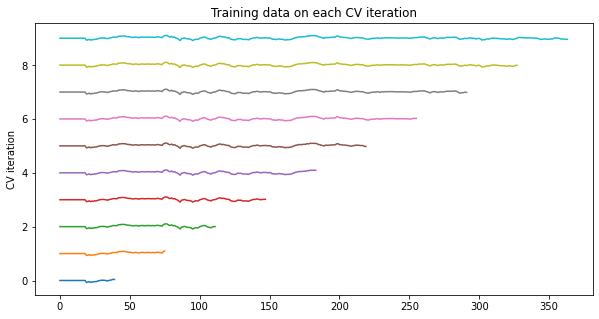

In [ ]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

**Note that the size of the training set grew each time when you used the time series cross-validation object. This way, the time points you predict are always after the timepoints we train on.**

## Stationarity and stability


### Stationarity

<div class=""><p>First, let's confirm what we know about stationarity. Take a look at these time series.</p>
<p><img src="https://assets.datacamp.com/production/repositories/1536/datasets/65d99f5db427747ff63b52e8d47ff02bec0dc17c/ch4_multiplechoice.png" alt=""></p>
<p>Which of the following time series do you think are not stationary?</p></div>

<pre>
Possible Answers

C only

D and C

B only

<b>B and C</b>

</pre>

**C begins to trend upward partway through, while B shows a large increase in variance mid-way through, making both of them non-stationary.**

### Bootstrapping a confidence interval

<div class=""><p>A useful tool for assessing the variability of some data is the bootstrap. In this exercise, you'll write your own bootstrapping function that can be used to return a bootstrapped confidence interval.</p>
<p>This function takes three parameters: a 2-D array of numbers (<code>data</code>), a list of percentiles to calculate (<code>percentiles</code>), and the number of boostrap iterations to use (<code>n_boots</code>). It uses the <code>resample</code> function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.</p></div>

Instructions
<li>The function should loop over the number of bootstraps (given by the parameter <code>n_boots</code>) and: <ul>
<li>Take a random sample of the data, with replacement, and calculate the mean of this random sample </li>
<li>Compute the percentiles of <code>bootstrap_means</code> and return it</li></ul></li>

In [ ]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

**You can use this function to assess the variability of your model coefficients.**

### Calculating variability in model coefficients

<div class=""><p>In this lesson, you'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. You'll investigate the coefficients of the model, as well as the uncertainty in its predictions.</p>
<p>Begin by assessing the <em>stability</em> (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data. </p>
<p>An instance of the Linear regression object (<code>model</code>) is available in your workpsace. Also, the arrays <code>X</code> and <code>y</code> (the data) are available too.</p></div>

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lnunesAI/Datacamp/main/2-machine-learning-scientist-with-python/9-machine-learning-for-time-series-data-in-python/datasets/prices_1762x13.csv')

In [ ]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
feature_names = df.columns[:-1].values

In [ ]:
#@title ⠀ { display-mode: "form" }
times_scores = pd.DatetimeIndex(['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
               '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
               '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
               '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
               '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
               '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
               '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
               '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
               '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
               '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
               '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
               '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
               '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
               '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28',
               '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07',
               '2014-07-30', '2014-08-22', '2014-09-17', '2014-10-10',
               '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20',
               '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28',
               '2015-05-21', '2015-06-16', '2015-07-10', '2015-08-04',
               '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09',
               '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18',
               '2016-03-14', '2016-04-07', '2016-05-02', '2016-05-25',
               '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31',
               '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07'], name='date')

model = LinearRegression()

Instructions 1/2
<ul>
<li>Initialize a <code>TimeSeriesSplit</code> cross-validation object</li>
<li>Create an array of all zeros to collect the coefficients. </li>
<li>Iterate through splits of the cross-validation object. On each iteration:</li>
<li>Fit the model on training data</li>
<li>Collect the model's coefficients for analysis later</li>
</ul>

In [ ]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

Instructions 2/2
<p>Finally, calculate the 95% confidence interval for each coefficient in <code>coefficients</code> using the <code>bootstrap_interval()</code> function you defined in the previous exercise. You can run <code>bootstrap_interval?</code> if you want a refresher on the parameters that this function takes.</p>

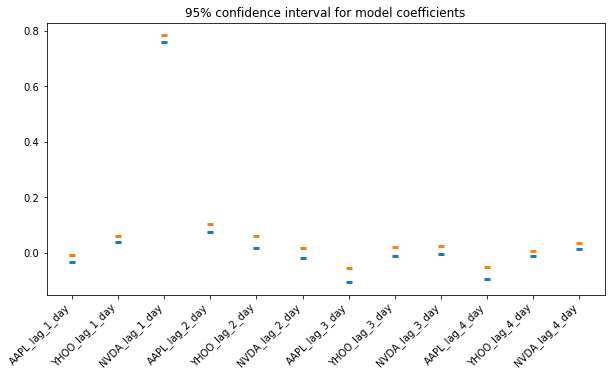

In [ ]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

**You've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time!**

### Visualizing model score variability over time


<div class=""><p>Now that you've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the <code>TimeSeriesSplit</code> object will use successively-later indices for each test set. This means that you can treat the <em>scores</em> of your validation as a time series. You can visualize this over time in order to see how the model's performance changes over time.</p>
<p>An instance of the Linear regression model object is stored in <code>model</code>, a cross-validation object in <code>cv</code>, and data in <code>X</code> and <code>y</code>.</p></div>

In [ ]:
from sklearn.model_selection import cross_val_score
from functools import partial

In [ ]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    # Create our empty array we'll fille with the results
    if data.ndim == 1:
        data = data[:, np.newaxis]
    data = np.atleast_2d(data)
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

Instructions 1/2
<ul>
<li>Calculate the cross-validated scores of the model on the data (using a custom scorer we defined for you, <code>my_pearsonr</code> along with <code>cross_val_score</code>).  </li>
<li>Convert the output scores into a pandas Series so that you can treat it as a time series.  </li>
<li>Bootstrap a rolling confidence interval for the mean score using <code>bootstrap_interval()</code>.</li>
</ul>

In [ ]:
from sklearn.model_selection import cross_val_score

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


Instructions 2/2
<p>Run the given code to plot the results.</p>

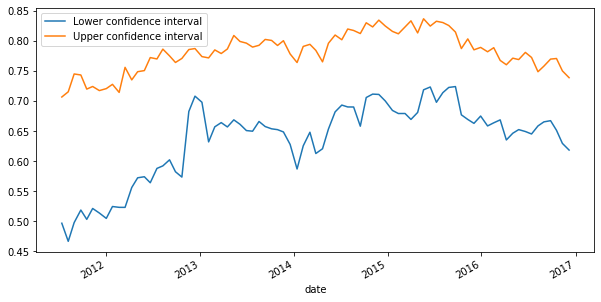

In [ ]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

**You plotted a rolling confidence interval for scores over time. This is useful in seeing when your model predictions are correct.**

### Accounting for non-stationarity

<div class=""><p>In this exercise, you will again visualize the variations in model scores, but now for data that changes its statistics over time. </p>
<p>An instance of the Linear regression model object is stored in <code>model</code>, a cross-validation object in <code>cv</code>, and the data in <code>X</code> and <code>y</code>.</p></div>

Instructions
<ul>
<li>Create an empty DataFrame to collect the results. </li>
<li>Iterate through multiple window sizes, each time creating a new <code>TimeSeriesSplit</code> object. </li>
<li>Calculate the cross-validated scores (using a custom scorer we defined for you, <code>my_pearsonr</code>) of the model on training data.</li>
</ul>

In [ ]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

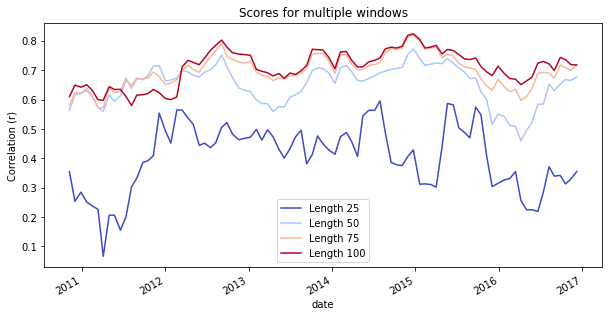

In [ ]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()

**notice how in some stretches of time, longer windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.**